In [175]:
import pandas as pd
import numpy as np

In [176]:
data = pd.read_csv('forecast.csv')

data = data[['ds', 'TimeGPT']]

In [177]:
data.head()

,ds,TimeGPT
0,2024-12-18,360.89035
1,2024-12-19,374.65182
2,2024-12-20,369.84670
3,2024-12-21,306.38250
4,2024-12-22,328.67822


In [178]:
MATERIAL_CODE = 10036545

In [179]:
data['ds'] = pd.to_datetime(data['ds'])


In [180]:
data['TimeGPT']=data['TimeGPT'].apply(lambda x: np.ceil(x))

In [181]:
data.head()

,ds,TimeGPT
0,2024-12-18,361.0
1,2024-12-19,375.0
2,2024-12-20,370.0
3,2024-12-21,307.0
4,2024-12-22,329.0


In [182]:
data.rename(columns={'ds': 'Date', 'TimeGPT': 'Forecasted Consumption'}, inplace=True)

In [183]:
df = pd.read_csv('../data/processed/inventory.csv')

In [184]:
max_date = df['Date'].max()

In [185]:
actual_consumption = df[(df['Material Code'] == MATERIAL_CODE)]['Material Issued'].to_list()

In [186]:
import numpy as np

# Parameters
z = 1.65  # Service level factor for 95% service level
lead_time = 90  # Lead time in days

# Calculate standard deviation of actual daily consumption
sigma = np.std(actual_consumption)

# Calculate safety stock
safety_stock = np.ceil(z * sigma * np.sqrt(lead_time))

print(f"Standard Deviation of Consumption: {sigma:.2f}")
print(f"Safety Stock: {safety_stock:.2f} units")


Standard Deviation of Consumption: 3836.30
Safety Stock: 60051.00 units


In [187]:
filter_df = df[(df['Material Code'] == MATERIAL_CODE) & (df['Date'] == max_date)]

In [188]:
filter_df

,Material Code,Material Description,Unit,Date,Open Stock,Material Issued,Material Received,Closing Stock,Prefix,Type,PDT,BFP,Price
727127,10036545,CABLE; AL XLPE LT ABC 2X10 MM2,M,2024-12-17,38416.0,0.0,0.0,38416.0,1,Material,90,0,84.38


In [189]:
current_stock = filter_df['Closing Stock'].values[0]
lead_time = filter_df['PDT'].values[0]
moq = 2000

In [190]:
if (len(data) < lead_time): 
    range_val = (lead_time - len(data)) 
else: 
    range_val = lead_time
range_val

60

In [191]:
max_forecast_date = data['Date'].max()
max_forecast_date

Timestamp('2025-01-16 00:00:00')

In [192]:
# Calculate average daily demand from the 30-day forecast
average_daily_demand = data['Forecasted Consumption'].mean()

In [193]:
extended_dates = pd.date_range(start=max_forecast_date, periods=range_val+1, freq='D')[1:]
extended_forecast = pd.DataFrame({
    'Date': extended_dates,
    'Forecasted Consumption': [average_daily_demand] * len(extended_dates)
})

# Combine the 30-day forecast and the extended forecast
full_forecast = pd.concat([data, extended_forecast]).reset_index(drop=True)

In [194]:
len(full_forecast)

90

In [196]:
# Lead time demand: Sum of forecasted consumption for 90 days
lead_time_demand = full_forecast['Forecasted Consumption'][:lead_time].sum()

# Reorder Point (ROP)
rop = lead_time_demand + safety_stock
print(f"Reorder Point (ROP): {rop:0.1f}")

Reorder Point (ROP): 105609.0


In [198]:
# Calculate cumulative consumption
full_forecast['Cumulative Consumption'] = full_forecast['Forecasted Consumption'].cumsum()

# Calculate daily stock levels
full_forecast['Stock Level'] = current_stock - full_forecast['Cumulative Consumption']

# Determine reorder date
reorder_date = full_forecast.loc[full_forecast['Stock Level'] <= rop, 'Date'].iloc[0]
print(f"Reorder Date: {reorder_date}")

Reorder Date: 2024-12-18 00:00:00


In [199]:
# Calculate Replenishment Quantity
replenishment_quantity = max(rop, moq)

# Calculate replenishment date
replenishment_date = reorder_date + pd.Timedelta(days=lead_time)

print(f"Replenishment Quantity: {replenishment_quantity:.2f} units")
print(f"Replenishment Date: {replenishment_date}")

Replenishment Quantity: 105609.00 units
Replenishment Date: 2025-03-18 00:00:00


In [200]:
reorder_quantity = max(rop, moq)

In [201]:
print(f"Reorder Point (ROP): {rop:.2f} units")
print(f"Reorder Quantity: {reorder_quantity:.2f} units")

Reorder Point (ROP): 105609.00 units
Reorder Quantity: 105609.00 units


In [204]:
# Fill the gap between Reorder Date and Replenishment Date
gap_dates = pd.date_range(start=reorder_date, end=replenishment_date - pd.Timedelta(days=1))

# Create a DataFrame for the gap with zero consumption and constant stock level
gap_data = pd.DataFrame({
    'Date': gap_dates,
    'Deferred Consumption': 0,  # No consumption during the gap
    'Cumulative Consumption': 0,  # No additional consumption
    'Stock Level': current_stock  # Stock remains constant
})

# Combine the gap data with the deferred forecast data
complete_forecast = pd.concat([gap_data, deferred_forecast]).reset_index(drop=True)

# Ensure proper sorting of dates
complete_forecast.sort_values('Date', inplace=True)

# View the updated complete forecast
display(complete_forecast[['Date', 'Deferred Consumption', 'Cumulative Consumption', 'Stock Level']])


,Date,Deferred Consumption,Cumulative Consumption,Stock Level
0,2024-12-18,0.0,0.0,38416.0
1,2024-12-19,0.0,0.0,38416.0
2,2024-12-20,0.0,0.0,38416.0
3,2024-12-21,0.0,0.0,38416.0
4,2024-12-22,0.0,0.0,38416.0
...,...,...,...,...
115,2025-04-12,558.0,12693.0,92916.0
116,2025-04-13,547.0,13240.0,92369.0
117,2025-04-14,617.0,13857.0,91752.0
118,2025-04-15,659.0,14516.0,91093.0


Information Extracted from the Simulation:
1. Current Stock: 12.00 units
2. Total Forecasted Consumption (Actual Forecast): 30.00 units
3. MOQ: 500.00 units
4. Stock Level at the End of Actual Forecast Period (2025-01-16 00:00:00): 0.00 units
5. Stock Level at the End of Extended Forecast Period (2025-08-02 00:00:00): 404.00 units
6. Reorder Point (ROP): 292.00 units
7. Lead Time Demand: 120.00 units
8. Reorder Date: 2024-12-18 00:00:00
9. Replenishment Date: 2025-04-17 00:00:00
10. Replenishment Quantity: 500.00 units


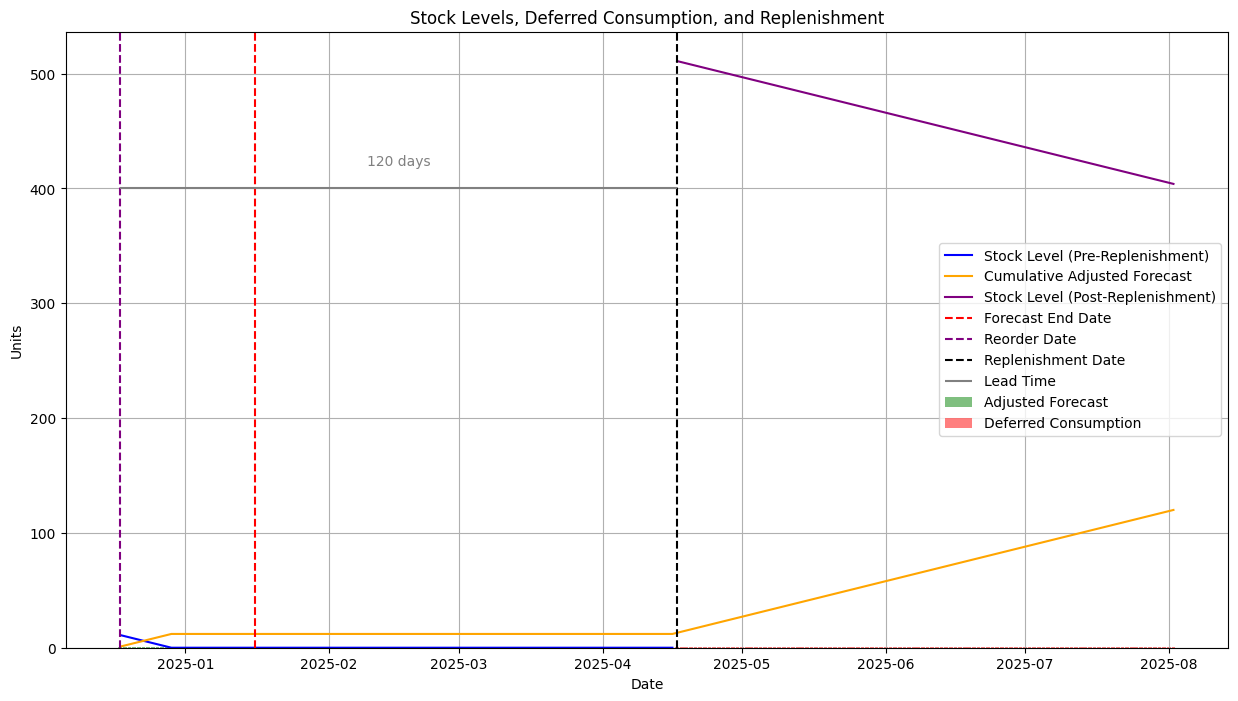

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load forecast data
data = pd.read_csv('forecast.csv')
data = data[['ds', 'TimeGPT']]
data['ds'] = pd.to_datetime(data['ds'])
data['TimeGPT'] = data['TimeGPT'].apply(lambda x: np.ceil(x))
data.rename(columns={'ds': 'Date', 'TimeGPT': 'Forecasted Consumption'}, inplace=True)

# Material code and inventory details
MATERIAL_CODE = 10001128
df = pd.read_csv('../data/processed/inventory.csv')
max_date = df['Date'].max()

# Historical consumption for safety stock calculation
actual_consumption = df[df['Material Code'] == MATERIAL_CODE]['Material Issued'].to_list()
service_level = 0.95
z = norm.ppf(service_level)
sigma = np.std(actual_consumption)  # Standard deviation
lead_time = 90  # Lead time in days
safety_stock = np.ceil(z * sigma * np.sqrt(lead_time))

# Current stock and lead time for the material
filter_df = df[(df['Material Code'] == MATERIAL_CODE) & (df['Date'] == max_date)]
current_stock = filter_df['Closing Stock'].values[0]
lead_time = int(filter_df['PDT'].values[0])

moq_df = pd.read_csv('../data/processed/moq.csv')
moq = moq_df[moq_df['Material Code'] == MATERIAL_CODE]['MOQ'].values[0]

# Extend forecast if necessary
if len(data) < lead_time:
    range_val = lead_time - len(data)
    max_forecast_date = data['Date'].max()
    avg_daily_demand = data['Forecasted Consumption'].mean()
    extended_dates = pd.date_range(start=max_forecast_date, periods=range_val + 1, freq='D')[1:]
    extended_forecast = pd.DataFrame({
        'Date': extended_dates,
        'Forecasted Consumption': [avg_daily_demand] * len(extended_dates)
    })
    full_forecast = pd.concat([data, extended_forecast]).reset_index(drop=True)
else:
    full_forecast = data

# Handle cases where forecast exceeds lead time
if len(full_forecast) > lead_time:
    full_forecast = full_forecast[:lead_time]

# Calculate lead time demand and ROP
lead_time_demand = full_forecast['Forecasted Consumption'].sum()
rop = lead_time_demand + safety_stock

# Calculate cumulative consumption and stock levels
full_forecast['Cumulative Consumption'] = full_forecast['Forecasted Consumption'].cumsum()
full_forecast['Stock Level'] = np.maximum(0, current_stock - full_forecast['Cumulative Consumption'])  # Ensure stock level >= 0

# Determine reorder date
if current_stock > rop:
    reorder_date = "No Reorder Needed"  # Sufficient stock
else:
    reorder_date = full_forecast.loc[full_forecast['Stock Level'] <= rop, 'Date'].iloc[0]

# Calculate replenishment details
if reorder_date != "No Reorder Needed":
    replenishment_quantity = max(rop, moq)
    replenishment_date = reorder_date + pd.Timedelta(days=lead_time)
else:
    replenishment_quantity = 0
    replenishment_date = None

# Handle deferred consumption
def handle_deferred_consumption(full_forecast, current_stock, replenishment_date):
    remaining_stock = current_stock
    deferred_consumption = []
    deferred_dates = []
    adjusted_forecast = []

    for i, row in full_forecast.iterrows():
        if remaining_stock > 0:
            if row['Forecasted Consumption'] <= remaining_stock:
                adjusted_forecast.append(row['Forecasted Consumption'])
                remaining_stock -= row['Forecasted Consumption']
            else:
                adjusted_forecast.append(remaining_stock)
                deferred_consumption.append(row['Forecasted Consumption'] - remaining_stock)
                deferred_dates.append(row['Date'])
                remaining_stock = 0
        else:
            adjusted_forecast.append(0)
            deferred_consumption.append(row['Forecasted Consumption'])
            deferred_dates.append(row['Date'])

    deferred_data = pd.DataFrame({
        'Date': pd.date_range(start=replenishment_date, periods=len(deferred_consumption), freq='D'),
        'Deferred Consumption': deferred_consumption
    })

    full_forecast['Adjusted Forecast'] = adjusted_forecast
    full_forecast['Cumulative Adjusted Forecast'] = full_forecast['Adjusted Forecast'].cumsum()

    return full_forecast, deferred_data

# Apply deferred consumption logic
full_forecast['Deferred Consumption'] = 0
full_forecast, deferred_forecast = handle_deferred_consumption(full_forecast, current_stock, replenishment_date)
deferred_forecast['Cumulative Deferred Consumption'] = deferred_forecast['Deferred Consumption'].cumsum()

# Add stock level after replenishment
if replenishment_date:
    replenishment_stock = current_stock + replenishment_quantity
    post_replenishment_stock = replenishment_stock - full_forecast['Cumulative Consumption']
    post_replenishment_dates = pd.date_range(start=replenishment_date, periods=len(full_forecast), freq='D')
    replenishment_data = pd.DataFrame({
        'Date': post_replenishment_dates,
        'Stock Level': np.maximum(0, replenishment_stock - full_forecast['Cumulative Consumption'])
    })
    replenishment_data = replenishment_data[replenishment_data['Date'] <= deferred_forecast['Date'].max()]  # Truncate to deferred period

# Total forecasted consumption from the actual forecast period
total_forecast_consumption = data['Forecasted Consumption'].sum()

# Extract the stock level at the end of the actual forecast period
end_of_actual_forecast = data['Date'].max()
stock_at_end_of_actual_forecast = full_forecast.loc[full_forecast['Date'] == end_of_actual_forecast, 'Stock Level'].values[0]

# Extract the stock level at the end of the extended forecast period
if full_forecast['Date'].max() > deferred_forecast['Date'].max():
    end_of_extended_forecast = full_forecast['Date'].max()
    stock_at_end_of_extended_forecast = full_forecast.loc[full_forecast['Date'] == end_of_extended_forecast, 'Stock Level'].values[0]
else:
    end_of_extended_forecast = deferred_forecast['Date'].max()
    stock_at_end_of_extended_forecast = replenishment_data.loc[replenishment_data['Date'] == end_of_extended_forecast, 'Stock Level'].values[0]
    

# Print the extracted information
print("Information Extracted from the Simulation:")
print(f"1. Current Stock: {current_stock:.2f} units")
print(f"2. Total Forecasted Consumption (Actual Forecast): {total_forecast_consumption:.2f} units")
print(f"3. MOQ: {moq:.2f} units")
print(f"4. Stock Level at the End of Actual Forecast Period ({end_of_actual_forecast}): {stock_at_end_of_actual_forecast:.2f} units")
print(f"5. Stock Level at the End of Extended Forecast Period ({end_of_extended_forecast}): {stock_at_end_of_extended_forecast:.2f} units")
print(f"6. Reorder Point (ROP): {rop:.2f} units")
print(f"7. Lead Time Demand: {lead_time_demand:.2f} units")
if reorder_date != "No Reorder Needed":
    print(f"8. Reorder Date: {reorder_date}")
    print(f"9. Replenishment Date: {replenishment_date}")
    print(f"10. Replenishment Quantity: {replenishment_quantity:.2f} units")
else:
    print("8. No Reorder Needed (Stock is sufficient)")


full_forecast_copy = full_forecast.copy()
deferred_forecast_copy = deferred_forecast.copy()

full_forecast_copy.rename(columns={'Adjusted Forecast': 'Consumption'}, inplace=True)
deferred_forecast_copy.rename(columns={'Deferred Consumption': 'Consumption'}, inplace=True)

combined_df=pd.concat([full_forecast_copy[['Date', 'Consumption']], deferred_forecast_copy[['Date', 'Consumption']]]).reset_index(drop=True)

combined_df['Cumulative Consumption'] = combined_df['Consumption'].cumsum()



# Plot results
fig = plt.figure(figsize=(15, 8))

# Stock Level
plt.plot(full_forecast['Date'], full_forecast['Stock Level'], label='Stock Level (Pre-Replenishment)', color='blue')

# Adjusted Forecast
plt.bar(full_forecast['Date'], full_forecast['Adjusted Forecast'], label='Adjusted Forecast', color='green', alpha=0.5)

# Cumulative Adjusted Forecast
# plt.plot(full_forecast['Date'], full_forecast['Cumulative Adjusted Forecast'], label='Cumulative Adjusted Forecast', color='orange')
plt.plot(combined_df['Date'], combined_df['Cumulative Consumption'], label='Cumulative Adjusted Forecast', color='orange')

# Deferred Consumption
plt.bar(deferred_forecast['Date'], deferred_forecast['Deferred Consumption'], label='Deferred Consumption', color='red', alpha=0.5)

#plt.plot(deferred_forecast['Date'], deferred_forecast['Cumulative Deferred Consumption'] , label='Cumulative Deferred Consumption', color='violet')


# Stock Level Post-Replenishment
if replenishment_date:
    plt.plot(replenishment_data['Date'], replenishment_data['Stock Level'], label='Stock Level (Post-Replenishment)', color='purple')

plt.axvline(data['Date'].max(), color='red', linestyle='--', label='Forecast End Date')

# Reorder and Replenishment Dates
if reorder_date != "No Reorder Needed":
    plt.axvline(reorder_date, color='purple', linestyle='--', label='Reorder Date')
    plt.axvline(replenishment_date, color='black', linestyle='--', label='Replenishment Date')
    size_inches = fig.get_size_inches()
    dpi = fig.get_dpi()
    height_pixels = height_inches * dpi
    # Add a horizontal line between the two vertical lines
    # y_position = full_forecast['Stock Level'].max() * 2  # Set y-position (90% of max stock level for visibility)
    y_position = height_pixels/2
    plt.hlines(y=y_position, xmin=reorder_date, xmax=replenishment_date, color='gray', linestyle='-', label='Lead Time')

    # Annotate the horizontal line
    mid_date = reorder_date + (replenishment_date - reorder_date) / 2  # Midpoint between reorder and replenishment dates
    plt.text(mid_date, y_position + 20, f'{lead_time} days', ha='center', color='gray', fontsize=10)

# Plot settings
plt.title('Stock Levels, Deferred Consumption, and Replenishment')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid()
plt.show()


In [13]:
import pandas as pd
import numpy as np
import joblib
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder

# Load the trained XGBoost model
model_path = "best_xgboost_model_material_features_added.pkl"  # Replace with your actual model path
xgb_model = joblib.load(model_path)

# Load the data for reference (used for feature engineering and past data)
file_path = '../data/processed/inventory.csv'  # Replace with your actual data path
historical_data = pd.read_csv(file_path)

# Ensure Date is in datetime format
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
historical_data.sort_values('Date', inplace=True)

# Assuming 'features' is a list containing the feature names used during model training
# Replace this with your actual list of features
features = ['Open Stock',
 'Closing Stock',
 'Day',
 'Year',
 'Material Code Encoded',
 'Lag_1_Issued',
 'Rolling_7_Issued',
 'Weekday',
 'BFP',
 'Lag_1_Amount_Issued',
 'Rolling_7_Amount_Issued',
 'Cumulative_Issued',
 'Cumulative_Received',
 'Cumulative_Amount_Issued',
 'Price_Issued_Interaction',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',
 'Quarter_2',
 'Quarter_3',
 'Quarter_4']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on all unique Material Codes in the historical data
label_encoder.fit(historical_data['Material Code'])


# Define the forecasting function
def forecast_material_issued(material_code, horizon, historical_data):
    # Filter the data for the given Material Code
    material_data = historical_data[historical_data['Material Code'] == material_code].copy()
    
    # If no historical data exists for the given Material Code, raise an error
    if material_data.empty:
        raise ValueError(f"No historical data found for Material Code: {material_code}")
    
    # Ensure 'Amount Issued' exists
    if 'Amount Issued' not in material_data.columns:
        material_data['Amount Issued'] = material_data['Price'] * material_data['Material Issued']
    
    # Generate the future dates for the forecast horizon
    last_date = material_data['Date'].max()
    forecast_dates = [last_date + timedelta(days=i) for i in range(1, horizon + 1)]
    
    # Initialize forecast DataFrame
    forecast_df = pd.DataFrame({'Date': forecast_dates})
    forecast_df['Material Code'] = material_code

    # Initialize stocks and cumulative variables using historical data
    last_issued = material_data['Material Issued'].iloc[-1]
    last_amount_issued = material_data['Amount Issued'].iloc[-1]
    rolling_7_issued = material_data['Material Issued'].iloc[-7:].mean() if len(material_data) >= 7 else 0
    rolling_7_amount_issued = material_data['Amount Issued'].iloc[-7:].mean() if len(material_data) >= 7 else 0
    cumulative_issued = material_data['Material Issued'].sum()
    cumulative_received = material_data['Material Received'].sum()
    cumulative_amount_issued = material_data['Amount Issued'].sum()
    last_price = material_data['Price'].iloc[-1]
    open_stock = material_data['Closing Stock'].iloc[-1] 

    forecast_values = []
    for date in forecast_dates:
        # Feature Engineering for the current date
        current_features = {
            'Day': date.day,
            'Year': date.year,
            'Weekday': date.weekday(),
            'Lag_1_Issued': last_issued, 
            'Lag_1_Amount_Issued': last_amount_issued,
            'Rolling_7_Issued': rolling_7_issued,
            'Rolling_7_Amount_Issued': rolling_7_amount_issued,
            'Cumulative_Issued': cumulative_issued,  # Use historical data only
            'Cumulative_Received': cumulative_received,
            'Cumulative_Amount_Issued': cumulative_amount_issued,
            'Price_Issued_Interaction': last_price * last_issued,
            'Open Stock': open_stock,
            'Closing Stock': open_stock,  # Initially same as open stock
            'Material Code Encoded': label_encoder.transform([material_code])[0], 
            'BFP': material_data['BFP'].iloc[-1] if 'BFP' in material_data.columns else 0,
        }
        
        # Add dummy-encoded features for Month and Quarter
        for month in range(2, 13):
            current_features[f'Month_{month}'] = 1 if date.month == month else 0
        for quarter in range(2, 5):
            current_features[f'Quarter_{quarter}'] = 1 if (date.month - 1) // 3 + 1 == quarter else 0
        
        # Convert to DataFrame and predict
        input_features = pd.DataFrame([current_features])
        input_features = input_features[features]  # Ensure the column order matches the model's features
        predicted_value = xgb_model.predict(input_features)[0]
        forecast_values.append(predicted_value)
        
        # Update values for the next iteration
        last_issued = predicted_value
        last_amount_issued = last_price * predicted_value 
        rolling_7_issued = (rolling_7_issued * 6 + predicted_value) / 7  # Update rolling mean
        rolling_7_amount_issued = (rolling_7_amount_issued * 6 + last_amount_issued) / 7
        cumulative_issued += predicted_value  # Keep historical cumulative value constant
        cumulative_amount_issued += last_amount_issued
        open_stock -= predicted_value  # Update closing stock for next day

    forecast_df['Material Issued'] = forecast_values
    return forecast_df

# Example Usage
material_code = 10036545  # Replace with a valid Material Code
forecast_horizon = 30  # Forecast for 30 days

forecast_result = forecast_material_issued(material_code, forecast_horizon, historical_data)
display(forecast_result)


,Date,Material Code,Material Issued
0,2024-12-18,10036545,27.167740
1,2024-12-19,10036545,113.439590
2,2024-12-20,10036545,301.787323
3,2024-12-21,10036545,617.443420
4,2024-12-22,10036545,903.869751
5,2024-12-23,10036545,1272.494141
6,2024-12-24,10036545,3140.542725
7,2024-12-25,10036545,3388.046631
8,2024-12-26,10036545,6041.477539
9,2024-12-27,10036545,6002.984375


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import numpy as np
import joblib

# Load your data (use your actual file path)
file_path = '../data/processed/inventory.csv'
data = pd.read_csv(file_path)

data = data[data['Type'] == 'Material']
data['Date'] = pd.to_datetime(data['Date'])
data['Material Code'] = data['Material Code'].astype(str)

data.sort_values('Date', inplace=True)
data = data.dropna(subset=['Material Issued', 'Open Stock', 'Closing Stock', 'Price'])

# Calculate Amount Issued and Amount Received
data['Amount Issued'] = data['Price'] * data['Material Issued']
data['Amount Received'] = data['Price'] * data['Material Received']

# Feature Engineering
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Quarter'] = data['Date'].dt.quarter

# Add 1-day Lag Feature
data['Lag_1_Issued'] = data.groupby('Material Code')['Material Issued'].shift(1)
data['Lag_1_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].shift(1)

# Add 7-day Rolling Statistics
data['Rolling_7_Issued'] = data.groupby('Material Code')['Material Issued'].rolling(7).mean().reset_index(level=0, drop=True)
data['Rolling_7_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].rolling(7).mean().reset_index(level=0, drop=True)

# Add Seasonality Indicator (e.g., Weekday)
data['Weekday'] = data['Date'].dt.weekday  # 0=Monday, 6=Sunday

# Cumulative Features
data['Cumulative_Issued'] = data.groupby('Material Code')['Material Issued'].cumsum()
data['Cumulative_Received'] = data.groupby('Material Code')['Material Received'].cumsum()
data['Cumulative_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].cumsum()

# Interaction Features
data['Price_Issued_Interaction'] = data['Price'] * data['Material Issued']

# Fill NaN values introduced by lagging and rolling
data.fillna(0, inplace=True)

# Encode Material Code as a categorical feature
encoder = LabelEncoder()
data['Material Code Encoded'] = encoder.fit_transform(data['Material Code'])

# One-hot encode Month and Quarter
data = pd.get_dummies(data, columns=['Month', 'Quarter'], drop_first=True)

# Target and Features
features_1 = ['Open Stock', 'Closing Stock', 'Day', 'Year', 'Material Code Encoded', 'Lag_1_Issued', 'Rolling_7_Issued', 'Weekday', 'BFP', 'Lag_1_Amount_Issued', 'Rolling_7_Amount_Issued', 'Cumulative_Issued', 'Cumulative_Received', 'Cumulative_Amount_Issued', 'Price_Issued_Interaction'] + [col for col in data.columns if col.startswith('Month_') or col.startswith('Quarter_')]
X = data[features_1]
y = data['Material Issued']

In [9]:
features_1

['Open Stock',
 'Closing Stock',
 'Day',
 'Year',
 'Material Code Encoded',
 'Lag_1_Issued',
 'Rolling_7_Issued',
 'Weekday',
 'BFP',
 'Lag_1_Amount_Issued',
 'Rolling_7_Amount_Issued',
 'Cumulative_Issued',
 'Cumulative_Received',
 'Cumulative_Amount_Issued',
 'Price_Issued_Interaction',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',
 'Quarter_2',
 'Quarter_3',
 'Quarter_4']

In [20]:
params = {"n_estimators": 80, "max_depth": 15, "learning_rate": 0.043372000935757236, "subsample": 0.7157188226215301, "colsample_bytree": 0.9773657559025434}

In [21]:
model = XGBRegressor(**params)

In [24]:
model.fit(X, y)

/home/azeem/Documents/Graduate_Project/iba-inventory-management-project/project_env/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9773657559025434, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.043372000935757236, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
model_path = "best_xgboost_model_material_features_added.pkl"
joblib.dump(model, model_path)

['best_xgboost_model_material_features_added.pkl']